In [1]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
print(':INFO: to run this visualization, you need to `pip install tensorwatch pillow` ')

import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorwatch.saliency import saliency
from tensorwatch import image_utils, imagenet_utils, pytorch_utils

from model import Model
from dataset import TrainDataset, TestDataset
from utils import get_predictions

:INFO: to run this visualization, you need to `pip install tensorwatch, pillow` 


In [2]:
CKPT_PATH = ''
IMAGE_FOLDER = 'data/samples'
GPU = True


if not CKPT_PATH:
    print(':WARNING: please fill in the path to checkpoint at CKPT_PATH')
    
if not IMAGE_FOLDER:
    print(':WARNING: please fill in the path to image folder at IMAGE_FOLDER')

print(":INFO: if GPU is unavailable in the machine, please set GPU = False")

:INFO: if GPU is unavailable in the machine, please set GPU = False


In [3]:
# initialize model
class ModelWrapper(nn.Module):
    """Require wrapper for model because tensorwatch expects differently"""
    
    def __init__(self, model):
        """Initialize the model wrapper"""
        super(ModelWrapper, self).__init__()
        self.model = model
    
    def forward(self, input_tensor):
        """Perform the forward pass"""
        logits, _, _ = self.model(input_tensor)
        return logits

model_info = torch.load(CKPT_PATH, map_location='cpu')
base_model = Model(ckpt=CKPT_PATH, gpu=GPU)
model = ModelWrapper(base_model).eval()
if GPU:
    model = model.cuda()

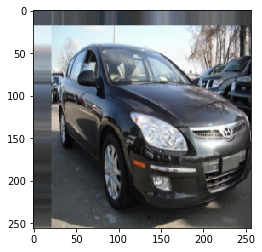

In [4]:
# get the images
def convert_normalized_image_to_numpy(image):
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    image = image.cpu().data.numpy()
    image = np.transpose(image, (1, 2, 0))
    image = (image * std + mean) * 255
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image
    
dataset = TestDataset(
    image_folder=IMAGE_FOLDER,
    shape=model_info['input_size']
)

filename, image = dataset[0]
image_numpy = convert_normalized_image_to_numpy(image)

# print, the first image, can already goes through normalization 
image_utils.show_image(image_numpy)

In [5]:
# get model prediction
if GPU:
    image = image.cuda()
    
with torch.no_grad():
    logit = model(image.unsqueeze(0))
    logit = logit.squeeze()
    logit = torch.softmax(logit, dim=0)
    logit = logit.cpu().data.numpy()
    predicted_idx, predicted_str = get_predictions(logit)
    
    print('Prediction index:', predicted_idx[0])
    print('Prediction string:', predicted_str[0])

Prediction index: 138
Prediction string: Hyundai Elantra Touring Hatchback 2012


In [6]:
# perform lime optimization
input_tensor = imagenet_utils.image2batch(Image.fromarray(image_numpy))
prediction_tensor = pytorch_utils.int2tensor(138)
results = saliency.get_image_saliency_results(model, Image.fromarray(image_numpy), input_tensor, prediction_tensor, methods=['lime_imagenet'])

/home/john/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


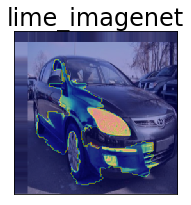

In [7]:
# get the plot
figure = saliency.get_image_saliency_plot(results)